In [1]:
import numpy as np
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import timm
import random
from sklearn.model_selection import train_test_split

import os
import cv2
from PIL import Image
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
from skimage import io, transform
from skimage.transform import resize
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
dir_names = os.listdir('./Cats_lapkins/')
dict1 = dict()
for i in dir_names:
    print(len(os.listdir('./Cats_lapkins/'+i)))
    dict1[i]=os.listdir('./Cats_lapkins/'+i)
        
data = pd.DataFrame({'names':dict1.keys(), 'images':dict1.values()})
data

242
42
48
42
42
42
243
243
242
27
242
42
42
42
42
42
42
42
274
257
42
42
42
42
42
242
42
42
42
42
42
42
42
42
242
42
42
32
242
242
42
42
242
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42
42


,names,images
0,Абиссинская кошка,"[Abyssinian_1.jpg, Abyssinian_10.jpg, Abyssini..."
1,Американская короткошерстная кошка,"[Американская короткошерстная кошка 1.jpg, Аме..."
2,Американский бобтейл,"[1.jpg, 2.jpg, 3.jpg, 4.jpg, 5.jpg, 6.jpg, Аме..."
3,Американский керл,"[Американский керл 1.jpg, Американский керл 10..."
4,Балинезийская кошка,"[Балинезийская кошка 1.jpg, Балинезийская кошк..."
...,...,...
57,Шотландская вислоухая кошка,"[Шотландская вислоухая кошка 1.jpg, Шотландска..."
58,Шотландская прямоухая кошка,"[Шотландская прямоухая кошка 1.jpg, Шотландска..."
59,Экзотическая кошка,"[Экзотическая кошка 1.jpg, Экзотическая кошка ..."
60,Эльф,"[Эльф 1.jpg, Эльф 10.jpg, Эльф 11.jpg, Эльф 12..."


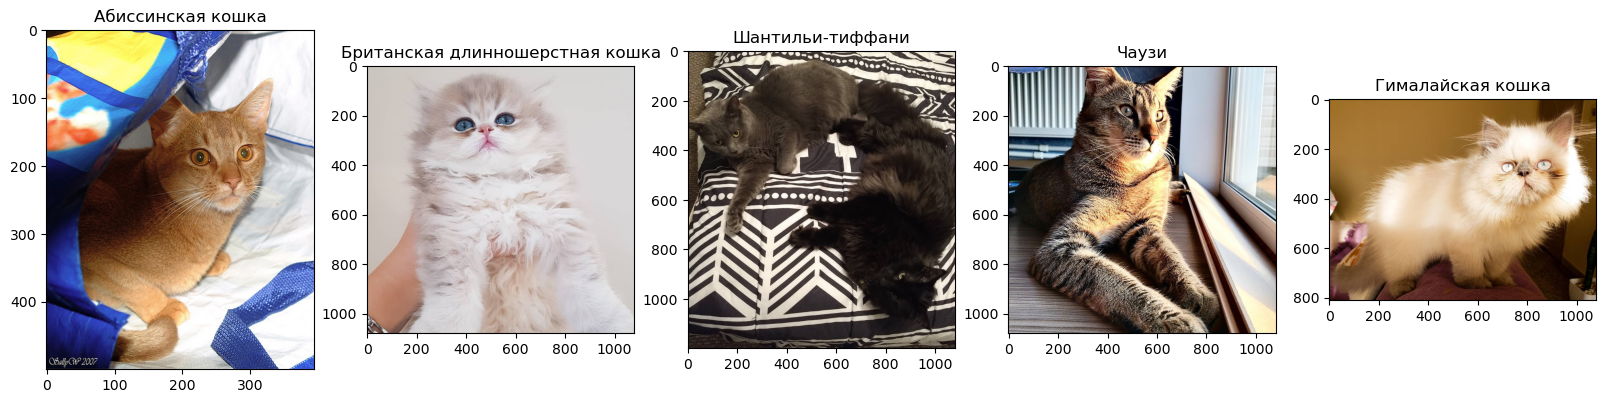

In [4]:
a = [list(dict1.keys())[i] for i in [np.random.randint(0,len(list(dict1.keys()))) for i in range(5)]]
s_names = ['./Cats_lapkins/'+i+'/'+dict1[i][np.random.randint(0,len(i))] for i in a]
imgs = []
for img in s_names:
    img = Image.open(img)
    imgs.append(np.array(img))

f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
for i, axis in enumerate(axes):
    axes[i].grid(False)
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(a[i])
plt.show()

In [5]:
class CatsDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_split_data(root_dir, train_size=0.8, val_size=0.1, test_size=0.1, seed=42):
    labels = os.listdir(root_dir)
    images = []
    image_labels = []

    for label in labels:
        label_dir = os.path.join(root_dir, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                images.append(os.path.join(label_dir, filename))
                image_labels.append(labels.index(label))

    train_images, test_images, train_labels, test_labels = train_test_split(
        images, image_labels, train_size=train_size + val_size, random_state=seed, stratify=image_labels)

    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, train_size=val_size / (test_size + val_size), random_state=seed, stratify=test_labels)

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_split_data('./Cats_lapkins/')

train_dataset = CatsDataset(train_images, train_labels, transform=transform)
val_dataset = CatsDataset(val_images, val_labels, transform=transform1)
test_dataset = CatsDataset(test_images, test_labels, transform=transform1)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
labels = len(os.listdir('./Cats_lapkins/'))
print(labels)
model1 = timm.create_model('efficientnet_b3', pretrained=True, num_classes=labels)
model1.to(device);

62


In [9]:
len(train_dataset)

4528

In [16]:
def train_model(model, train_loader, val_loader, device, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_acc = 0.0
    best_model_weights = deepcopy(model.state_dict())

    for epoch in tqdm(range(num_epochs), desc='Epoch Progress'):
        model.train()  # Переключение в режим обучения
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Training', leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1} - Training loss: {epoch_loss}')

        # Валидация
        model.eval()  # Переключение в режим оценки
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {epoch_val_loss}, Accuracy: {100 * correct / total}%')
        
        if epoch_val_loss < best_acc or best_acc == 0:
            best_acc = epoch_val_loss
            best_model_weights = deepcopy(model.state_dict())

    print('Finished Training')
    model.load_state_dict(best_model_weights)  # Загрузка лучших весов после обучения

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_model(model1, train_loader, val_loader, device)


Epoch 1 Training:  16%|██████████▏                                                    | 64/397 [00:23<01:55,  2.89it/s]


Epoch 1 Training:  33%|████████████████████▎                                         | 130/397 [00:47<01:28,  3.03it/s]


Epoch 1 Training:  49%|██████████████████████████████▌                               | 196/397 [01:10<01:16,  2.61it/s]


Epoch 1 Training:  66%|████████████████████████████████████████▉                     | 262/397 [01:34<00:45,  2.98it/s]


Epoch 1 Training:  83%|███████████████████████████████████████████████████▏          | 328/397 [01:57<00:20,  3.44it/s]


Epoch 1 Training:  99%|█████████████████████████████████████████████████████████████▌| 394/397 [02:20<00:00,  3.02it/s]


Epoch 1 Training: 100%|██████████████████████████████████████████████████████████████| 397/397 [02:22<00:00,  2.71it/s]
                                                                                                                       

Epoch 1 - Training loss: 1.967876607284738



Overall Epoch Progress:   6%|███▍                                                      | 1/17 [02:28<39:40, 148.80s/it]

Validation Loss: 2.017718496529952, Accuracy: 44.255319148936174%



Overall Epoch Progress:   6%|███▍                                                      | 1/17 [02:34<41:11, 154.47s/it]

KeyboardInterrupt



не оч

In [10]:
labels = len(os.listdir('./Cats_lapkins/'))
print(labels)
model = timm.create_model('resnet50', pretrained=True, num_classes=labels)
model.to(device);

62


In [11]:
def train_model(model, train_loader, val_loader, device, num_epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_acc = 0.0
    best_model_weights = deepcopy(model.state_dict())

    for epoch in tqdm(range(num_epochs), desc='Epoch Progress'):
        model.train()  # Переключение в режим обучения
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Training', leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1} - Training loss: {epoch_loss}')

        # Валидация
        model.eval()  # Переключение в режим оценки
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {epoch_val_loss}, Accuracy: {100 * correct / total}%')
        
        if epoch_val_loss < best_acc or best_acc == 0:
            best_acc = epoch_val_loss
            best_model_weights = deepcopy(model.state_dict())

    print('Finished Training')
    model.load_state_dict(best_model_weights)  # Загрузка лучших весов после обучения

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, val_loader, device)


Epoch Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 1 - Training loss: 2.568732369953478


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.9606413543224335, Accuracy: 51.19047619047619%


Epoch 2 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 2 - Training loss: 1.5188173210956681


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.6209731251001358, Accuracy: 55.55555555555556%


Epoch 3 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 3 - Training loss: 1.0749532315932528


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.6001355350017548, Accuracy: 56.74603174603175%


Epoch 4 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 4 - Training loss: 0.7065569880143018


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.7725898623466492, Accuracy: 58.73015873015873%


Epoch 5 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 5 - Training loss: 0.4637755135625181


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.6148844361305237, Accuracy: 61.111111111111114%


Epoch 6 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 6 - Training loss: 0.26322777826391475


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.696721225976944, Accuracy: 59.523809523809526%


Epoch 7 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 7 - Training loss: 0.17023478988820398


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.9186498075723648, Accuracy: 61.507936507936506%


Epoch 8 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 8 - Training loss: 0.13391291612470654


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.7686084508895874, Accuracy: 63.492063492063494%


Epoch 9 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 9 - Training loss: 0.11219808152338988


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.714978039264679, Accuracy: 59.12698412698413%


Epoch 10 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10 - Training loss: 0.07396459897396378


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.9112203866243362, Accuracy: 59.523809523809526%


Epoch 11 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 11 - Training loss: 0.09143925664133169


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.9869636744260788, Accuracy: 58.333333333333336%


Epoch 12 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 12 - Training loss: 0.11410043281043919


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.1143784523010254, Accuracy: 60.317460317460316%


Epoch 13 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 13 - Training loss: 0.10768550518296764


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.116778388619423, Accuracy: 57.93650793650794%


Epoch 14 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 14 - Training loss: 0.08935645696195499


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.3997480869293213, Accuracy: 52.38095238095238%


Epoch 15 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 15 - Training loss: 0.11450976238284312


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.3746230453252792, Accuracy: 55.55555555555556%


Epoch 16 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 16 - Training loss: 0.07907789802624726


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.1428879350423813, Accuracy: 62.301587301587304%


Epoch 17 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 17 - Training loss: 0.070415848262713


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.314755216240883, Accuracy: 57.142857142857146%


Epoch 18 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 18 - Training loss: 0.07957717295388468


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.021390825510025, Accuracy: 60.317460317460316%


Epoch 19 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 19 - Training loss: 0.05327967538590163


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.2532105445861816, Accuracy: 59.92063492063492%


Epoch 20 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 20 - Training loss: 0.039202110046638886


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.0701315850019455, Accuracy: 61.507936507936506%


Epoch 21 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 21 - Training loss: 0.019798108465103825


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.07852004468441, Accuracy: 62.698412698412696%


Epoch 22 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 22 - Training loss: 0.03897567401135104


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.2379291653633118, Accuracy: 61.904761904761905%


Epoch 23 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 23 - Training loss: 0.07535627351509748


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.970897227525711, Accuracy: 50.79365079365079%


Epoch 24 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 24 - Training loss: 0.07921534496225076


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.531030684709549, Accuracy: 54.76190476190476%


Epoch 25 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 25 - Training loss: 0.09680014621781212


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.2028525471687317, Accuracy: 58.73015873015873%


Epoch 26 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 26 - Training loss: 0.08476606324728264


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.4886288940906525, Accuracy: 57.93650793650794%


Epoch 27 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 27 - Training loss: 0.08591534319976477


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.4389933943748474, Accuracy: 52.38095238095238%


Epoch 28 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 28 - Training loss: 0.059740599153012455


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.619101107120514, Accuracy: 57.53968253968254%


Epoch 29 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 29 - Training loss: 0.047567396460783104


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.3964246958494186, Accuracy: 57.142857142857146%


Epoch 30 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 30 - Training loss: 0.03927624373595086


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 2.382380038499832, Accuracy: 59.92063492063492%
Finished Training


In [12]:
torch.save(model, 'complete_model1.pth')

In [13]:
def test_model(model, test_loader, device):
    model.eval()  # Переключение модели в режим оценки
    criterion = torch.nn.CrossEntropyLoss()  # Можно использовать тот же критерий потерь, что и при обучении

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Расчет средних потерь и точности
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy


In [14]:
# Загрузка модели
model = torch.load('complete_model1.pth')
model = model.to(device)  # Убедитесь, что модель на нужном устройстве

# Загрузка тестового DataLoader
# test_loader уже должен быть определен в вашем коде

# Выполнение тестирования
test_loss, test_accuracy = test_model(model, test_loader, device)

Test Loss: 1.6454, Accuracy: 56.35%


In [15]:
def train_model(model, train_loader, val_loader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    best_acc = 0.0
    best_model_weights = deepcopy(model.state_dict())

    for epoch in tqdm(range(num_epochs), desc='Epoch Progress'):
        model.train()  # Переключение в режим обучения
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1} Training', leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1} - Training loss: {epoch_loss}')

        # Валидация
        model.eval()  # Переключение в режим оценки
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {epoch_val_loss}, Accuracy: {100 * correct / total}%')
        
        if epoch_val_loss < best_acc or best_acc == 0:
            best_acc = epoch_val_loss
            best_model_weights = deepcopy(model.state_dict())

    print('Finished Training')
    model.load_state_dict(best_model_weights)  # Загрузка лучших весов после обучения

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_model(model, train_loader, val_loader, device)


Epoch Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 1 - Training loss: 0.6067734910568721


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.2617124021053314, Accuracy: 64.28571428571429%


Epoch 2 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 2 - Training loss: 0.4394726576939435


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.2494511678814888, Accuracy: 64.28571428571429%


Epoch 3 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 3 - Training loss: 0.3595623047104184


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.253355249762535, Accuracy: 66.66666666666667%


Epoch 4 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 4 - Training loss: 0.28764332998806325


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.2664470672607422, Accuracy: 65.47619047619048%


Epoch 5 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 5 - Training loss: 0.23158156703895247


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.3294983357191086, Accuracy: 65.07936507936508%


Epoch 6 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 6 - Training loss: 0.18686033129482202


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.3677495792508125, Accuracy: 64.28571428571429%


Epoch 7 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 7 - Training loss: 0.15701105970312174


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.3504580557346344, Accuracy: 65.07936507936508%


Epoch 8 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 8 - Training loss: 0.11934132462131306


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.354426234960556, Accuracy: 64.28571428571429%


Epoch 9 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 9 - Training loss: 0.09651760717617794


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.3976266086101532, Accuracy: 65.07936507936508%


Epoch 10 Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch 10 - Training loss: 0.07329533727918293


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 1.3564835786819458, Accuracy: 67.06349206349206%
Finished Training


In [16]:
torch.save(model, 'complete_model2_00001.pth')

In [17]:
# Загрузка модели
model = torch.load('complete_model2_00001.pth')
model = model.to(device)  # Убедитесь, что модель на нужном устройстве

# Загрузка тестового DataLoader
# test_loader уже должен быть определен в вашем коде

# Выполнение тестирования
test_loss, test_accuracy = test_model(model, test_loader, device)

Test Loss: 1.4228, Accuracy: 60.32%


In [45]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

names = ['Абиссинская кошка',
 'Американская короткошерстная кошка',
 'Американский бобтейл',
 'Американский керл',
 'Балинезийская кошка',
 'Бамбино',
 'Бенгальская кошка',
 'Бирманская кошка',
 'Бомбейская кошка',
 'Британская длинношерстная кошка',
 'Британская короткошерстная кошка',
 'Бурманская кошка',
 'Бурмилла',
 'Гавана браун',
 'Гималайская кошка',
 'Девон-рекс',
 'Донской сфинкс',
 'Европейская короткошерстная кошка',
 'Египетская мау',
 'Канадский сфинкс',
 'Корат',
 'Корниш-рекс',
 'Курильский бобтейл',
 'Лаперм',
 'Манчкин',
 'Мейн-кун',
 'Меконгский бобтейл',
 'Мэнкс',
 'Невская маскарадная кошка',
 'Немецкий рекс',
 'Нибелунг',
 'Норвежская лесная кошка',
 'Ориентальная кошка',
 'Оцикет',
 'Персидская кошка',
 'Петерболд',
 'Пиксибоб',
 'Рагамаффин',
 'Русская голубая кошка',
 'Рэгдолл',
 'Саванна (Ашера)',
 'Селкирк-рекс',
 'Сиамская кошка',
 'Сибирская кошка',
 'Сингапурская кошка',
 'Скукум',
 'Сноу-шу',
 'Сококе',
 'Сомалийская кошка',
 'Тайская кошка',
 'Тойгер',
 'Тонкинская кошка',
 'Турецкая ангора',
 'Турецкий ван',
 'Чаузи',
 'Шантильи-тиффани',
 'Шартрез',
 'Шотландская вислоухая кошка',
 'Шотландская прямоухая кошка',
 'Экзотическая кошка',
 'Эльф',
 'Японский бобтейл']

def predict_image(image_path, model, device):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    image_tensor = transform(image).unsqueeze(0)  
    
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)
        prediction = output.argmax()  

    return prediction

model2 = torch.load('complete_model2_00001.pth')
model2.eval()

image_path = 'test.jpg'
prediction = predict_image(image_path, model2, device)
print(f'Predicted class index: {prediction}')
names[int(prediction)]

Predicted class index: 48


'Сомалийская кошка'

In [18]:
import os
import re

def delete_images(directory, max_number_length=5):
    # Проходим по всем файлам в указанной директории
    for filename in os.listdir(directory):
        # Используем регулярное выражение для поиска чисел в имени файла
        match = re.search(r'\d+', filename)
        if match:
            number = match.group(0)
            # Проверяем длину найденного числа
            if len(number) > max_number_length:
                # Полный путь к файлу
                file_path = os.path.join(directory, filename)
                # Удаление файла
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Укажите путь к директории с изображениями
for i in os.listdir('./Cats_lapkins/'):
    path_to_images = './Cats_lapkins/'+i
    delete_images(path_to_images)


Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-13743713_251.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-16485182_247.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-16734355_246.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-17704905_241.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-35021741_239.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-35374431_238.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-36865042_237.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-37771828_235.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-38036164_232.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-38400864_231.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-38514815_230.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-38554587_227.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-38643353_226.jpg
Deleted: ./Cats_lapkins/Абиссинская кошка\Abyssinian-38646425_225.jpg
Deleted: ./Cats_lapk

Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18578371_9142.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18639509_9137.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18644243_9136.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18677923_9131.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18743978_9120.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18768504_9112.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18959912_9091.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18984467_9088.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-18988309_9085.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-19015704_9082.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-19032421_9078.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-19043494_9075.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-19182607_9042.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-19212155_9034.jpg
Deleted: ./Cats_lapkins/Бенгальская кошка\Bengal-19239430_9029

Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33086533_513.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33424918_500.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33510370_492.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33523925_490.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33567545_488.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33599649_485.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33936655_476.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-33939602_475.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-34160639_472.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-34162975_471.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-34162996_470.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-34306297_468.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-34306324_467.jpg
Deleted: ./Cats_lapkins/Египетская мау\Egyptian_Mau-34347972_466.jpg
Deleted: ./Cats_lapkins/Египетская

Deleted: ./Cats_lapkins/Нибелунг\36472351_291.jpg
Deleted: ./Cats_lapkins/Нибелунг\36523705_288.jpg
Deleted: ./Cats_lapkins/Нибелунг\36543867_286.jpg
Deleted: ./Cats_lapkins/Нибелунг\36626213_285.jpg
Deleted: ./Cats_lapkins/Нибелунг\36723131_283.jpg
Deleted: ./Cats_lapkins/Нибелунг\36851244_281.jpg
Deleted: ./Cats_lapkins/Нибелунг\37112304_275.jpg
Deleted: ./Cats_lapkins/Нибелунг\37112380_274.jpg
Deleted: ./Cats_lapkins/Нибелунг\38115276_245.jpg
Deleted: ./Cats_lapkins/Нибелунг\38125522_244.jpg
Deleted: ./Cats_lapkins/Нибелунг\38238258_241.jpg
Deleted: ./Cats_lapkins/Нибелунг\38644477_235.jpg
Deleted: ./Cats_lapkins/Нибелунг\39307931_227.jpg
Deleted: ./Cats_lapkins/Нибелунг\39393965_224.jpg
Deleted: ./Cats_lapkins/Нибелунг\39421411_222.jpg
Deleted: ./Cats_lapkins/Нибелунг\39747282_215.jpg
Deleted: ./Cats_lapkins/Нибелунг\39944821_209.jpg
Deleted: ./Cats_lapkins/Нибелунг\40033347_208.jpg
Deleted: ./Cats_lapkins/Нибелунг\40088674_206.jpg
Deleted: ./Cats_lapkins/Нибелунг\40089111_205.jpg


Deleted: ./Cats_lapkins/Ориентальная кошка\26156044_1702.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26157466_1701.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26405657_1685.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26430017_1683.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26430173_1682.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26454383_1678.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26481623_101.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26541828_1671.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26542667_1669.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26595646_1665.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26599725_1664.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26765549_1642.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26813794_1635.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26919402_1614.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26934796_1612.jpg
Deleted: ./Cats_lapkins/Ориентальная кошка\26971273_1605.jpg
Deleted: ./Cats_lapkins/О

Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27359275_5594.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27371691_5588.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27443101_5567.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27525304_5542.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27761369_5475.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27768015_5473.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-27921804_5425.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28013256_5397.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28186838_5338.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28238656_5320.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28257579_5313.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28274457_5304.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28468819_5244.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28527403_5231.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28586053_5203.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28659094_5181.jpg
Deleted: ./Cats_lapkins/Рэгдолл\Ragdoll-28690300_5178.jpg
Deleted: ./Cat

Deleted: ./Cats_lapkins/Тонкинская кошка\37150395_159.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\37167617_158.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\37477829_149.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\37543741_148.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\37670895_146.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\37801494_141.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\37965589_140.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\38691316_132.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\38753546_131.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\38824957_129.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\38879374_128.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\38930037_127.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\38992607_125.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\39123001_124.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\39170211_123.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\39511029_118.jpg
Deleted: ./Cats_lapkins/Тонкинская кошка\39589745_117.jpg
Deleted: ./Cat

Deleted: ./Cats_lapkins/Экзотическая кошка\22691835_1215.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\22734474_1214.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\22825059_1210.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\22831346_1209.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\22892749_1208.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\22919121_1207.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\22977925_1205.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23072402_1200.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23152673_1199.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23248161_1195.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23551128_1180.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23614790_1177.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23676774_1172.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23696777_1170.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23783705_1168.jpg
Deleted: ./Cats_lapkins/Экзотическая кошка\23783715_1167.jpg
Deleted: ./Cats_lapkins/

In [17]:
os.listdir('./Cats_lapkins/')

['Абиссинская кошка',
 'Американская короткошерстная кошка',
 'Американский бобтейл',
 'Американский керл',
 'Балинезийская кошка',
 'Бамбино',
 'Бенгальская кошка',
 'Бирманская кошка',
 'Бомбейская кошка',
 'Британская длинношерстная кошка',
 'Британская короткошерстная кошка',
 'Бурманская кошка',
 'Бурмилла',
 'Гавана браун',
 'Гималайская кошка',
 'Девон-рекс',
 'Донской сфинкс',
 'Европейская короткошерстная кошка',
 'Египетская мау',
 'Канадский сфинкс',
 'Корат',
 'Корниш-рекс',
 'Курильский бобтейл',
 'Лаперм',
 'Манчкин',
 'Мейн-кун',
 'Меконгский бобтейл',
 'Мэнкс',
 'Невская маскарадная кошка',
 'Немецкий рекс',
 'Нибелунг',
 'Норвежская лесная кошка',
 'Ориентальная кошка',
 'Оцикет',
 'Персидская кошка',
 'Петерболд',
 'Пиксибоб',
 'Рагамаффин',
 'Русская голубая кошка',
 'Рэгдолл',
 'Саванна (Ашера)',
 'Селкирк-рекс',
 'Сиамская кошка',
 'Сибирская кошка',
 'Сингапурская кошка',
 'Скукум',
 'Сноу-шу',
 'Сококе',
 'Сомалийская кошка',
 'Тайская кошка',
 'Тойгер',
 'Тонкин